# Coche autónomo mediante Deep Learning

Autor: Andrés Martínez Martínez

## Import libraries

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# common use
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

# images
from imgaug import augmenters as iaa
from PIL import Image
import cv2

# machine learning
import tensorflow as tf
from sklearn.model_selection import train_test_split

print( f'tf.version: {tf.__version__}')

tf.version: 2.8.2


##Load data

In [5]:
data_dir = '/content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/data'
model_output_dir = '/content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/trained-models'

In [6]:
def get_image_paths(directory, extension='png'):
  '''Returns ordered list of image paths in a directory'''

  file_names = os.listdir(directory)
  file_names = sorted(file_names)
  img_paths = [f'{directory}/{name}' for name in file_names if name[-4:] == f'.{extension}']

  return img_paths

img_paths = get_image_paths(data_dir + '/manual-images-v2/images')
steering_angles = [int(name[-7:-4]) for name in img_paths]

## Check data

number of images: 8695
number of angles: 8695


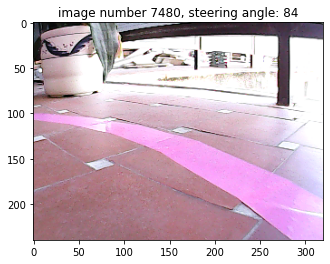

In [7]:
print('number of images: %d' % len(img_paths))
print('number of angles: %d' % len(steering_angles))

# show an image and its angle
index = np.random.randint(0, len(img_paths) - 1)
plt.imshow(Image.open(img_paths[index]))
plt.title(f'image number {index}, steering angle: {steering_angles[index]}')
plt.show()

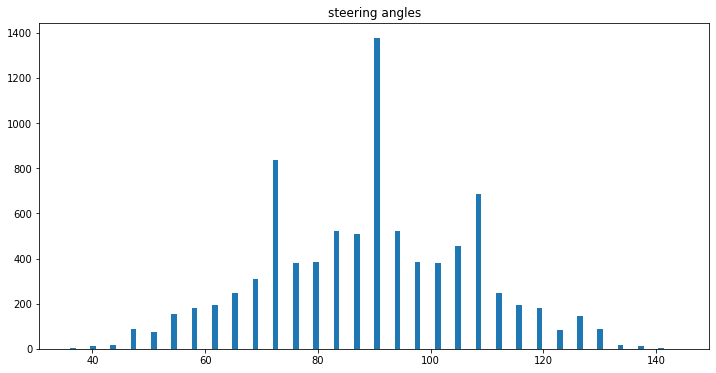

In [8]:
# check distribution of steering angles
fig, axes = plt.subplots(figsize=(12,6))
plt.hist(steering_angles, bins=30, width=1)
plt.title('steering angles')
plt.show()

## Flip images (only once)

In [9]:
def flip_driving_frames(frame_paths, frame_angles, output_dir=False):
  '''Flips horizontally all images from a given directory and saves them with the angle in their names changed to 180 - previous_angle'''

  img_dir = frame_paths[0][:-23]
  
  if not output_dir:
    output_dir = img_dir
  
  for i in range(len(frame_paths)):
    
    img = cv2.imread(frame_paths[i])
    img = cv2.flip(img,1)

    # change angle
    img_angle = 180 - frame_angles[i]
    img_angle = str(img_angle)
    zero_angle = img_angle.zfill(3)

    # new path
    img_name = f'{frame_paths[i][-21:-9]}i-a{zero_angle}.png'
    img_path = f'{output_dir}/{img_name}'

    cv2.imwrite(img_path, img)

#flip_driving_frames(img_paths, val_angles, data_dir + '/validation/images')

## Get training and validation datasets

Validation dataset from new circuit

In [10]:
val_img_paths = get_image_paths(data_dir + '/validation/images')
val_angles = [int(name[-7:-4]) for name in val_img_paths]

train_img_paths = img_paths
train_angles = steering_angles

Validation dataset from loaded data

In [11]:
'''train_img_paths, val_img_paths, train_angles, val_angles = train_test_split(img_paths, steering_angles, test_size=0.1, random_state=176584)'''

'train_img_paths, val_img_paths, train_angles, val_angles = train_test_split(img_paths, steering_angles, test_size=0.1, random_state=176584)'

Validation dataset from loaded data and new circuit

In [12]:
'''train_img_paths, val_img_paths, train_angles, val_angles = train_test_split(img_paths, steering_angles, test_size=0.1, random_state=176584)

val_img_paths_2 = get_image_paths(data_dir + '/validation/images')
val_angles_2 = [int(name[-7:-4]) for name in val_img_paths_2]

val_img_paths += val_img_paths_2
val_angles += val_angles_2

random.Random(562589).shuffle(val_img_paths)
random.Random(562589).shuffle(val_angles)'''

"train_img_paths, val_img_paths, train_angles, val_angles = train_test_split(img_paths, steering_angles, test_size=0.1, random_state=176584)\n\nval_img_paths_2 = get_image_paths(data_dir + '/validation/images')\nval_angles_2 = [int(name[-7:-4]) for name in val_img_paths_2]\n\nval_img_paths += val_img_paths_2\nval_angles += val_angles_2\n\nrandom.Random(562589).shuffle(val_img_paths)\nrandom.Random(562589).shuffle(val_angles)"

## Check datasets

Show composition

In [13]:
print(f'Training set consisting of {len(train_img_paths)} images and {len(train_angles)} angles.')
print(f'Validation set consisting of {len(val_img_paths)} images and {len(val_angles)} angles.')
print(f'Validation set is {np.trunc(len(val_img_paths)/(len(train_img_paths)+len(val_img_paths))*100)}% of total data')

Training set consisting of 8695 images and 8695 angles.
Validation set consisting of 774 images and 774 angles.
Validation set is 8.0% of total data


Show distribution

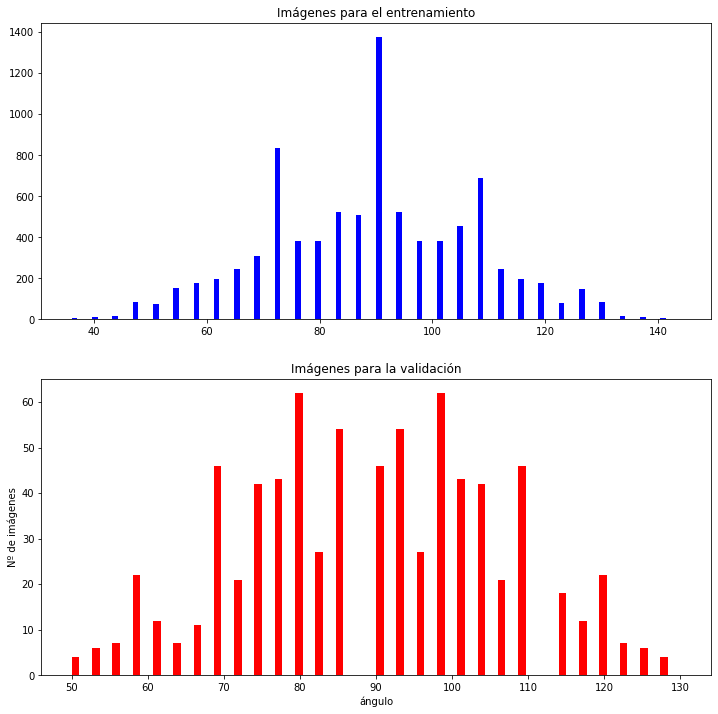

In [14]:
fig, axes = plt.subplots(2,1, figsize=(12, 12))
axes[0].hist(train_angles, bins=30, width=1, color='blue')
axes[0].set_title('Imágenes para el entrenamiento')
axes[1].hist(val_angles, bins=30, width=1, color='red')
axes[1].set_title('Imágenes para la validación')
plt.xlabel('ángulo')
plt.ylabel('Nº de imágenes')
plt.show()

Show a sample

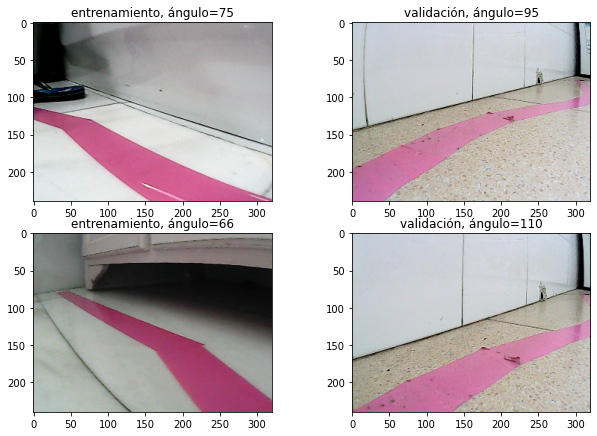

In [16]:
ncol = 2
nrow = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(9, 6))
fig.tight_layout()

for i in range(nrow):
  index = np.random.randint(0, len(val_angles) - 1)
  axes[i][0].imshow(cv2.cvtColor(cv2.imread(train_img_paths[index*10]), cv2.COLOR_BGR2RGB))
  axes[i][0].set_title(f'entrenamiento, ángulo={train_angles[index*10]}')
  axes[i][1].imshow(cv2.cvtColor(cv2.imread(val_img_paths[index]), cv2.COLOR_BGR2RGB))
  axes[i][1].set_title(f'validación, ángulo={val_angles[index]}')

##Augment functions and generators (unused)

In [17]:
def flip_images(img_paths, steering_angles):
  ''' Flips all images and its steering angles into two lists '''

  aug_images = []
  new_st_angles = []

  for i in range(len(img_paths)):

    image = cv2.imread(img_paths[i])
    aug_images.append(image)
    new_st_angles.append(steering_angles[i])
  
    # add flipped image
    aug_images.append(cv2.flip(image,1))
    new_st_angles.append(180 - steering_angles[i])

  random.Random(870652).shuffle(aug_images)
  random.Random(870652).shuffle(new_st_angles)

  return aug_images, new_st_angles

def flip(image, steering_angle):
  flipped_image = cv2.flip(image,1)
  steering_angle = 180 - steering_angle

  return flipped_image, steering_angle

def blur(image):
  ksize = np.random.randint(1,5)
  blurred_image = cv2.blur(image, (ksize,ksize))

  return blurred_image

def change_brightness(image):
    brightness = iaa.Multiply((0.5, 1.2))
    image = brightness.augment_image(image)

    return image


# randomly augment an image
def image_augment(image, steering_angle):
  if np.random.rand() < 0.5:
    image, steering_angle = flip(image, steering_angle)
  if np.random.rand() < 0.5:
    image = blur(image)
  if np.random.rand() < 0.5:
    image = change_brightness(image)

  return image, steering_angle

Functions for augmenting with a custom batch generator

In [18]:
'''def batch_generator(image_paths, steering_angles, batch_size):

  batch_images = []
  batch_steering_angles = []
  seed = 123

  for i in range(batch_size):
    index = random.Random(i+seed).randint(0, len(image_paths) - 1)
    img = cv2.imread(image_paths[index])
    
    img_paths, steering_angle = image_augment(img, steering_angles[index])

    img = image_preprocess(img)

    batch_images.append(img)
    batch_steering_angles.append(steering_angle)

  yield(np.asarray(batch_images), np.asarray(batch_steering_angles))

#test

nrows = 2
ncols = 2

X_train_batch, y_train_batch = next(batch_generator(X_train, y_train, nrows))
X_valid_batch, y_valid_batch = next(batch_generator(X_val, y_val, nrows))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6))
#fig.tight_layout()

for i in range(nrows):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])'''

NameError: ignored

Generator using tf.keras.utils.Sequence

In [19]:
class data_generator(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.Random(123).shuffle(self.x)
            np.random.Random(123).shuffle(self.y)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        '''return np.array([image_preprocess(image_augment(cv2.imread(i))) for i in batch_x]), np.array(batch_y)'''

        images = []

        for i in range(len(batch_x)):
          img = cv2.imread(batch_x[i])

          img, batch_y[i] = image_augment(img, batch_y[i])
          img = image_preprocess(img)
          
          images.append(img)
        
        return np.array(images), np.array(batch_y)

## Build deep learning model

In [20]:
model = tf.keras.Sequential([

  # augment layers
  #model.add(tf.keras.layers.RandomContrast(0.1))
  #model.add(tf.keras.layers.RandomBrightness(0.1, value_range=(0, 1)))

  # conv layers
  tf.keras.layers.Conv2D(24, 5, strides=(2, 2), input_shape=(66, 200, 3), activation='elu'),
  tf.keras.layers.Conv2D(36, 5, strides=(2, 2), activation='elu'),
  tf.keras.layers.Conv2D(48, 5, strides=(2, 2), activation='elu'),
  tf.keras.layers.Conv2D(64, 3, activation='elu'),
  tf.keras.layers.Conv2D(64, 3, activation='elu'),

  # fully connected layers
  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(100, activation='elu'),
  tf.keras.layers.Dense(50, activation='elu'),
  tf.keras.layers.Dense(10, activation='elu'),

  # output layer
  tf.keras.layers.Dense(1)
])

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=opt, metrics='MeanAbsoluteError')

model.build((32,66,200,3))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

## Adjust data for model requirements

In [22]:
def image_preprocess(image_path):
  '''Loads an image and modifies it to match model requirements'''
  
  img = cv2.imread(image_path)
  
  # cut top of image
  height = len(img)
  img = img[int(height/2):,:,:]

  # resize
  img = cv2.resize(img, (200,66))

  # change to RGB
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # normalize
  img = img / 255

  return img

In [ ]:
'''Preprocess and convert lists to numpy arrays'''

X_train = np.asarray([image_preprocess(i) for i in train_img_paths])
X_val = np.asarray([image_preprocess(i) for i in val_img_paths])

Y_train = np.asarray(train_angles)
Y_val = np.asarray(val_angles)

## Check preprocessed datasets

Show example of preprocessing

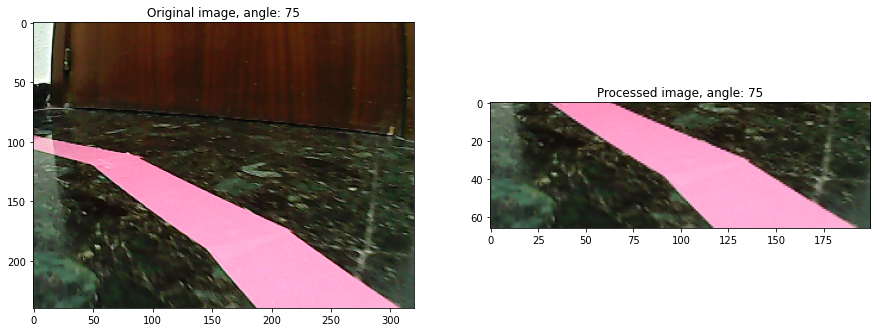

In [ ]:
index = np.random.randint(0, len(val_angles) - 1)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(Image.open(train_img_paths[index]))
axes[0].set_title(f'Original image, angle: {train_angles[index]}')
axes[1].imshow(X_train[index])
axes[1].set_title(f'Processed image, angle: {Y_train[index]}')
plt.show()

Print shape of datasets

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(8695, 66, 200, 3)
(774, 66, 200, 3)
(8695,)
(774,)


Show a sample

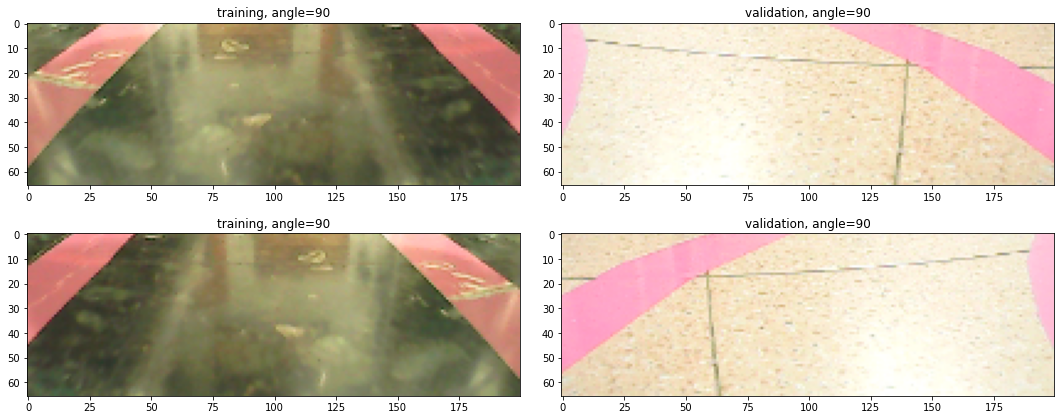

In [ ]:
ncol = 2
nrow = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    
    axes[i][0].imshow(X_train[i])
    axes[i][0].set_title(f'training, angle={Y_train[i]}')
    axes[i][1].imshow(X_val[i])
    axes[i][1].set_title(f'validation, angle={Y_val[i]}')

##Training

In [ ]:
history = None
trained_model_name = 'lane-nav-Nvidia-inv-moreimg'

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, trained_model_name + '-checkpoint.h5'), verbose=1, save_best_only=True)

history = model.fit(X_train, Y_train, batch_size=32,
                              epochs=10,
                              validation_data = (X_val, Y_val),
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_output_dir, trained_model_name + '.h5'))

Epoch 1/10
316/316 [==============================] - ETA: 0s - loss: 490.5774
Epoch 1: val_loss improved from inf to 292.24478, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/trained models/lane-nav-Nvidia-inv-moreimg-checkpoint.h5
316/316 [==============================] - 69s 216ms/step - loss: 490.5774 - val_loss: 292.2448
Epoch 2/10
316/316 [==============================] - ETA: 0s - loss: 313.1440
Epoch 2: val_loss improved from 292.24478 to 221.27431, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/trained models/lane-nav-Nvidia-inv-moreimg-checkpoint.h5
316/316 [==============================] - 68s 214ms/step - loss: 313.1440 - val_loss: 221.2743
Epoch 3/10
316/316 [==============================] - ETA: 0s - loss: 133.3016
Epoch 3: val_loss improved from 221.27431 to 57.99952, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/trained models

## Review learning curves

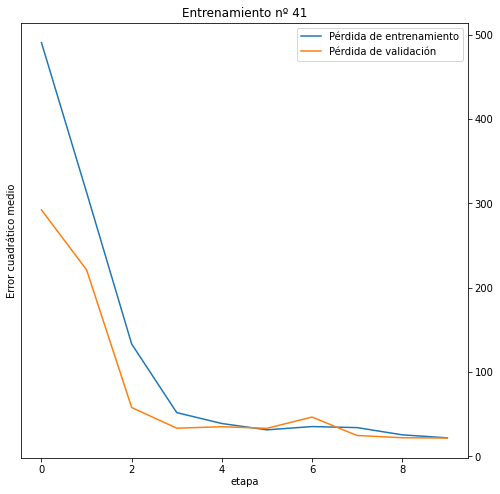

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(train_loss, label='Pérdida de entrenamiento')
ax.plot(val_loss, label='Pérdida de validación')
plt.legend(loc='upper right')
plt.ylabel('Error cuadrático medio')
plt.title('Entrenamiento nº 41')
plt.xlabel('etapa',labelpad=2)
ax.yaxis.tick_right()
plt.show()

#[465,213,55,41,34,27,25,23.4,20.3,20.7]
#[297,64,56,40,28,25,27,27,23,24]

## Fine-tuning

In [ ]:
# load saved model
model_name = 'lane-nav-Nvidia-inv-elu(20-23)'
trained_model = tf.keras.models.load_model(f'{model_output_dir}/{model_name}.h5')
new_name = f'{model_name}-ft2'

In [ ]:
# load new images
ft_img_paths = get_image_paths(data_dir + '/fine-tuning/images')
ft_angles = [int(name[-7:-4]) for name in ft_img_paths]

#flip_driving_frames(ft_img_paths, ft_angles)

X_train_ft = np.asarray([image_preprocess(i) for i in ft_img_paths])
X_train = np.concatenate((X_train, X_train_ft))
Y_train = np.concatenate((Y_train, ft_angles))

print(X_train.shape)
print(Y_train.shape)

TypeError: ignored

In [ ]:
# lower learning rate
trained_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003))

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, new_name + '-checkpoint.h5'), verbose=1, save_best_only=True)

history_ft = trained_model.fit(X_train, Y_train, batch_size=32,
                              epochs=5,
                              validation_data = (X_val, Y_val),
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_output_dir, model_name + '.h5'))

Epoch 1/5
316/316 [==============================] - ETA: 0s - loss: 25.9128
Epoch 1: val_loss improved from inf to 22.12651, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/trained models/lane-nav-Nvidia-inv-elu(20-23)-ft2-checkpoint.h5
316/316 [==============================] - 68s 212ms/step - loss: 25.9128 - val_loss: 22.1265
Epoch 2/5
316/316 [==============================] - ETA: 0s - loss: 22.3757
Epoch 2: val_loss improved from 22.12651 to 21.76738, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/trained models/lane-nav-Nvidia-inv-elu(20-23)-ft2-checkpoint.h5
316/316 [==============================] - 67s 212ms/step - loss: 22.3757 - val_loss: 21.7674
Epoch 3/5
316/316 [==============================] - ETA: 0s - loss: 20.9812
Epoch 3: val_loss improved from 21.76738 to 21.45376, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/trained models

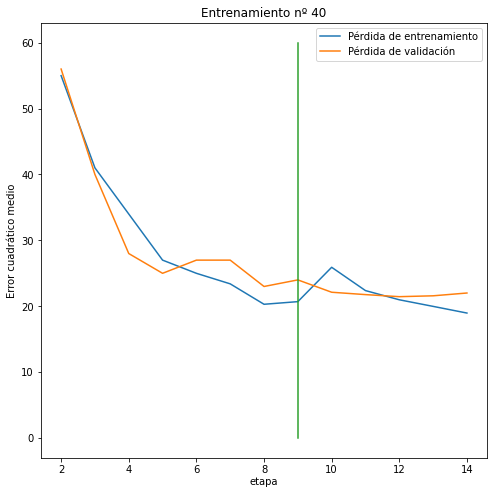

In [ ]:
train_loss = [55,41,34,27,25,23.4,20.3,20.7] + history_ft.history['loss']
val_loss = [56,40,28,25,27,27,23,24] + history_ft.history['val_loss']

plt.figure(figsize=(8,8))
plt.plot(range(2, len(train_loss) + 2), train_loss, label='Pérdida de entrenamiento')
plt.plot(range(2, len(train_loss) + 2), val_loss, label='Pérdida de validación')
plt.legend(loc='upper right')
plt.ylabel('Error cuadrático medio')
plt.title('Entrenamiento nº 40')
plt.xlabel('etapa',labelpad=2)
plt.plot([9,9],
         [0,60], label='Inicio del ajuste')
plt.show()

## Compile model for Coral Accelerator

In [ ]:
os.chdir(f'{model_output_dir}')
model = tf.keras.models.load_model('lane-nav-Nvidia-inv-elu(20-23).h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('lane-navigation-model-v4.tflite', 'wb') as f:
  f.write(tflite_model)